In [263]:
import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
import arff
import matplotlib.pyplot as plt
import copy

In [177]:
k = [1,2,3]
{c: None for c in k}

{1: None, 2: None, 3: None}

In [319]:
class HAC(BaseEstimator,ClusterMixin):

    def __init__(self, n_clusters=[3], link_type='single'): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.n_clusters = n_clusters
        self.clusters = None
        self.cluster_dict = {k: None for k in self.n_clusters}
        self.centers = {k: [] for k in self.n_clusters}
        self.instances_per_cluster = {k: [] for k in self.n_clusters}
        self.SSE = {k: [] for k in self.n_clusters}
        
    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        n, d = X.shape
        dist_matrix = np.linalg.norm(X - np.hstack([X for _ in range(n)]).reshape(n, n, d), axis=2)
        dist_matrix += np.diag(np.ones(n)*np.nan)
        self.clusters = np.arange(n).reshape(-1, 1).tolist()
        if self.link_type == 'single':
            self._single_link(X, dist_matrix)
        if self.link_type == 'complete':
            self._complete_link(X, dist_matrix)
        
        for k in self.n_clusters:
            for cluster in self.cluster_dict[k]:
                center = np.mean(X[cluster], axis=0)
                self.centers[k].append(center)
                self.instances_per_cluster[k].append(len(cluster))
                sse = np.linalg.norm(X[cluster] - center)**2
                self.SSE[k].append(sse)
            
        return self
    
    def _single_link(self, X, dist_matrix):
        n, d = X.shape
        k_min = min(self.n_clusters)
        m = len(self.clusters)
        while m > k_min:
            ind = np.nanargmin(dist_matrix)
            i = ind // n
            j = ind % n
            found_i = False
            found_j = False
            loc = []
            for k, cluster in enumerate(self.clusters):
                if i in cluster:
                    loc.append(k)
                    found_i = True
                elif j in cluster:
                    loc.append(k)
                    found_j = True
                if found_i and found_j:
                    break
            for inst1 in self.clusters[loc[0]]:
                for inst2 in self.clusters[loc[1]]:
                    dist_matrix[inst1, inst2] = np.nan
                    dist_matrix[inst2, inst1] = np.nan
            self.clusters[loc[0]] += self.clusters[loc[1]]
            del self.clusters[loc[1]]
            m -= 1
            if m in self.n_clusters:
                self.cluster_dict[m] = copy.deepcopy(self.clusters)
    
    def _complete_link(self, X, dist_matrix):
        n, d = X.shape
        k_min = min(self.n_clusters)
        m = len(self.clusters)
        while m > k_min:
            ind = np.nanargmin(dist_matrix)
            i = ind // n
            j = ind % n
            found_i = False
            found_j = False
            loc = []
            for k, cluster in enumerate(self.clusters):
                if i in cluster:
                    loc.append(k)
                    found_i = True
                elif j in cluster:
                    loc.append(k)
                    found_j = True
                if found_i and found_j:
                    break
            if len(self.clusters[loc[0]]) > 1 or len(self.clusters[loc[1]]) > 1:
                break
            for inst1 in self.clusters[loc[0]]:
                for inst2 in self.clusters[loc[1]]:
                    dist_matrix[inst1, inst2] = np.nan
                    dist_matrix[inst2, inst1] = np.nan
            self.clusters[loc[0]] += self.clusters[loc[1]]
            del self.clusters[loc[1]]
            m -= 1
            if m in self.n_clusters:
                self.cluster_dict[m] = copy.deepcopy(self.clusters)
        while m > k_min:
            curr_dists = np.zeros((m, m))
            for i, cluster1 in enumerate(self.clusters):
                for j, cluster2 in enumerate(self.clusters):
                    curr_dists[i,j] = np.max(dist_matrix[cluster1].T[cluster2])
            ind = np.nanargmin(curr_dists)
            i = ind // m
            j = ind % m
            self.clusters[i] += self.clusters[j]
            del self.clusters[j]
            m -= 1
            if m in self.n_clusters:
                self.cluster_dict[m] = copy.deepcopy(self.clusters)
            
            
    
    def save_clusters(self, filename, k):
        f = open(filename, "w+") 
        f.write("{:d}\n".format(k))
        f.write("{:.4f}\n\n".format(sum(self.SSE[k])))
        for i in range(k):
            f.write(np.array2string(self.centers[k][i], precision=4, separator=","))
            f.write("\n")
            f.write("{:d}\n".format(self.instances_per_cluster[k][i]))
            f.write("{:.4f}\n\n".format(self.SSE[k][i]))
        f.close()


In [320]:
def normalize(X, min_val=None, max_val=None):
    if min_val is None: min_val = np.nanmin(X, axis=0)
    if max_val is None: max_val = np.nanmax(X, axis=0)
    return (X - min_val) / (max_val - min_val)

class KMeans(BaseEstimator, ClusterMixin):
    """Basic k-means clustering class."""
    def __init__(self, n_clusters, max_iter=100, tol=1e-5):
        """Store clustering algorithm parameters.
        
        Parameters:
            n_clusters (int): How many clusters to compute.
            max_iter (int): The maximum number of iterations to compute.
            tol (float): The convergence tolerance.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.clusters = None
        self.centers = None
        self.instances_per_cluster = []
        self.SSE = []
    
    def fit(self, X, y=None, init_centers="random"):
        """Compute the cluster centers from random initial conditions.
        
        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        if init_centers == "random":
            old_centers = X[np.random.choice(len(X), size=self.n_clusters)]
        elif init_centers == "initial":
            old_centers = X[:self.n_clusters]
        else:
            raise ValueError("init_centers must be either 'random' or 'initial'")
        self.clusters = np.argmin(np.dstack([np.linalg.norm(X - old_centers[i], axis=1) 
                                             for i in range(self.n_clusters)]), axis=2).flatten()
        for _ in range(self.max_iter):
            new_centers = np.zeros_like(old_centers)
            for i in range(self.n_clusters):
                if len(X[self.clusters==i]) == 0:
                    new_centers[i] = X[np.random.choice(len(X))]
                else:
                    new_centers[i] = X[self.clusters==i].mean(axis=0)
            self.clusters = np.argmin(np.dstack([np.linalg.norm(X - new_centers[i], axis=1) 
                                                 for i in range(self.n_clusters)]), axis=2).flatten()
            if np.linalg.norm(old_centers - new_centers) < self.tol:
                break
        self.centers = new_centers
        for i in range(self.n_clusters):
            self.instances_per_cluster.append(sum(self.clusters==i))
            sse = np.linalg.norm(X[self.clusters==i] - km.centers[i])**2
            self.SSE.append(sse)
        
        return self
    
    def save_clusters(self, filename):
        f = open(filename, "w+") 
        f.write("{:d}\n".format(self.n_clusters))
        f.write("{:.4f}\n\n".format(sum(self.SSE)))
        for i in range(self.n_clusters):
            f.write(np.array2string(self.centers[i], precision=4, separator=","))
            f.write("\n")
            f.write("{:d}\n".format(self.instances_per_cluster[i]))
            f.write("{:.4f}\n\n".format(self.SSE[i]))
        f.close()

# Debug

## Kmeans

In [63]:
debug = arff.Arff(arff=r'abalone.arff', label_count=1)
X = normalize(debug[:])
km = KMeans(5)
km.fit(X, init_centers="initial")
km.save_clusters("my_kmeans_debug.txt")

## HAC single link

In [200]:
single = HAC(n_clusters=[5])
single.fit(X)
single.save_clusters("my_single_debug.txt", 5)

## HAC complete link

In [212]:
complete = HAC(n_clusters=[5], link_type="complete")
complete.fit(X)
complete.save_clusters("my_complete_debug.txt", 5)

HACClustering(link_type='complete', n_clusters=[5])

# Evaluation

## Kmeans

In [214]:
data = arff.Arff(arff=r'seismic-bumps_train.arff', label_count=2)
X = normalize(data[:, :-1])
km = KMeans(5)
km.fit(X, init_centers="initial")
km.save_clusters("evaluation_kmeans.txt")

## HAC Single

In [215]:
single = HAC(n_clusters=[5])
single.fit(X)
single.save_clusters("evaluation_hac_single.txt", 5)

## HAC Complete

In [216]:
complete = HAC(n_clusters=[5], link_type="complete")
complete.fit(X)
complete.save_clusters("evaluation_hac_complete.txt", 5)

# IRIS

In [336]:
iris = arff.Arff(arff=r'iris.arff', label_count=3)
X = iris[:, :-1]
y = iris[:, -1]
SSE_kmeans = []
SSE_single = []
SSE_complete = []
k_range = np.arange(2, 8)
for k in k_range:
    km = KMeans(k)
    km.fit(X)
    SSE_kmeans.append(sum(km.SSE))
single = HAC(n_clusters=k_range)
single.fit(X)
complete = HAC(n_clusters=k_range, link_type='complete')
complete.fit(X)
SSE_single = [sum(single.SSE[i]) for i in k_range]
SSE_complete = [sum(complete.SSE[i]) for i in k_range]

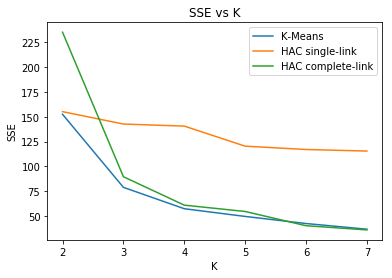

In [337]:
plt.plot(k_range, SSE_kmeans, label="K-Means")
plt.plot(k_range, SSE_single, label="HAC single-link")
plt.plot(k_range, SSE_complete, label="HAC complete-link")
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("SSE vs K")
plt.legend()
plt.show()

# Scikit-learn

In [290]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import pandas as pd
from sklearn import metrics

In [ ]:
def SSE_score(X, y, k):
    sse = 0
    for i in range(k):
        center = np.mean(X[y==i])
        sse += np.linalg.norm(X[y==i] - center)**2
    return sse

In [312]:
data = pd.read_csv("tripadvisor_review.csv")
data = data.iloc[:, 1:].to_numpy()
models = ["km", "hac_single", "hac_complete", "hac_avg", "hac_ward"]
sil_scores = {m: [] for m in models}
sse_scores = {m: [] for m in models}
ch_scores = {m: [] for m in models}
db_scores = {m: [] for m in models}
for k in range(2, 10):
    km = KMeans(n_clusters=k)
    hac_single = AgglomerativeClustering(n_clusters=k, linkage='single')
    hac_complete = AgglomerativeClustering(n_clusters=k, linkage='complete')
    hac_avg = AgglomerativeClustering(n_clusters=k, linkage='average')
    hac_ward = AgglomerativeClustering(n_clusters=k, linkage='ward')
    
    km.fit(data)
    hac_single.fit(data)
    hac_complete.fit(data)
    hac_avg.fit(data)
    hac_ward.fit(data)
    
    for m in models:
        sil_scores[m].append(metrics.silhouette_score(data, eval(m).labels_, metric='euclidean'))
        sse_scores[m].append(SSE_score(data, eval(m).labels_, k))
        ch_scores[m].append(metrics.calinski_harabasz_score(data, eval(m).labels_))
        db_scores[m].append(metrics.davies_bouldin_score(data, eval(m).labels_))

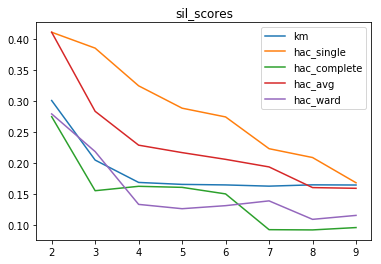

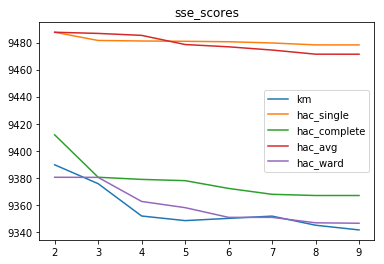

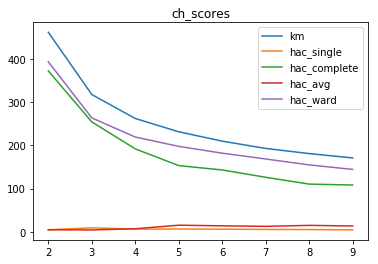

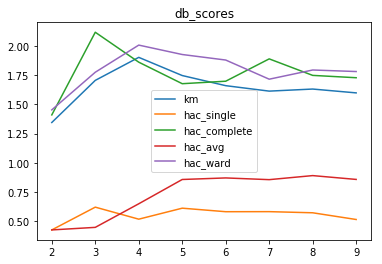

In [316]:
k_range = np.arange(2, 10)
for scores in ["sil_scores", "sse_scores", "ch_scores", "db_scores"]:
    for m in models:
        plt.plot(k_range, eval(scores)[m], label=m)
    plt.legend()
    plt.title(scores)
    plt.show()

In [293]:
data = pd.read_csv("tripadvisor_review.csv")
data = data.iloc[:, 1:].to_numpy()
sil_scores = []
sse_scores = []
ch_scores = []
db_scores = []
for k in range(2, 10):
    hac = AgglomerativeClustering(n_clusters=k, linkage='single')
    hac.fit(data)
    sil_scores.append(metrics.silhouette_score(data, km.labels_, metric='euclidean'))
    sse_scores.append(SSE_score(data, km.labels_, k))
    ch_scores.append(metrics.calinski_harabasz_score(data, km.labels_))
    db_scores.append(metrics.davies_bouldin_score(data, km.labels_))

(0.16458006851896287, 9347.905573244663)